# Dataframe subsetting and slicing

Date: Apr 14, 2020

Author: Rahul Bhadani

In this notebook, I will demonstrate how to get a subset of messages from the message dataframe read from a can-data CSV file. Let's start with reading a csv file.

In [1]:
import signal
import pandas as pd
import sys, math, time, datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
from matplotlib.pyplot import cm
import pickle
from strym import strymread
import strym
import seaborn as sea
import copy
plt.rcParams["figure.figsize"] = (16,5)

Loading BokehJS ...

In [2]:
datafolder = "/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/"
import glob
csvlist = glob.glob(datafolder+"*.csv")

num_of_files = len(csvlist)
print("Total number of datafiles in {} is {}.".format(datafolder, num_of_files))
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'


Total number of datafiles in /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/ is 8.


In [3]:
csvlist

['/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-15-36-24-479038__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-18-29-15-641040__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-18-09-36-362663__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-15-27-20-702814__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-19-57-11-286348__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-19-32-39-704415__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-10-35-13-966077__CAN_Messages.csv',
 '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_03/2020-03-03-20-15-01-595829__CAN_Messages.csv']

In [4]:
r0 = strymread(csvlist[0], dbcfile)

Let's see how original dataframe for first csvfile looks like

In [5]:
r0.dataframe

,Time,Buffer,Bus,MessageID,Message,MessageLength
Clock,,,,,,
2020-03-03 22:36:24.759860992,1.583275e+09,0000602c05004ef9130f038018000000,0,355,130f038018,5
2020-03-03 22:36:24.760409594,1.583275e+09,000080380800eef90000210056004084,0,452,0000210056004084,8
2020-03-03 22:36:24.761665106,1.583275e+09,00000030180058b4a5fff80000000025,1,384,a5fff80000000025,8
2020-03-03 22:36:24.762725592,1.583275e+09,0000403018004eb6a5fff80000000027,1,386,a5fff80000000027,8
2020-03-03 22:36:24.763091087,1.583275e+09,000060301800cbb6a5fff80000000028,1,387,a5fff80000000028,8
...,...,...,...,...,...,...
2020-03-03 23:21:06.934266090,1.583278e+09,000060500700666b0000000000008c00,0,643,0000000000008c,7
2020-03-03 23:21:06.935342073,1.583278e+09,0000c05c0800606dfff800087fe0004e,0,742,fff800087fe0004e,8
2020-03-03 23:21:06.935601950,1.583278e+09,0000403a08000f6e9904fa54ffae0073,0,466,9904fa54ffae0073,8


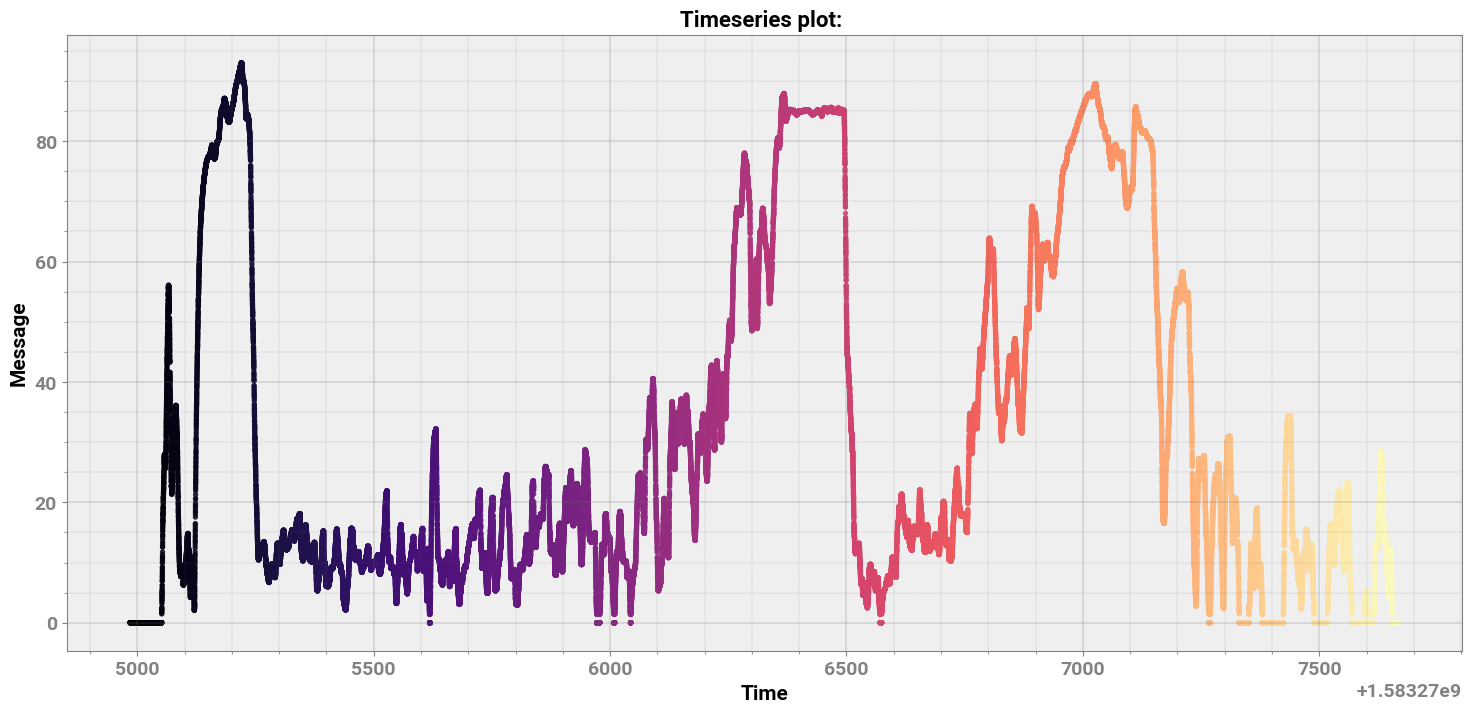

In [26]:
speed = r0.speed()
plt.rcParams["figure.figsize"] = (16,5)
strym.plt_ts(speed)

In [8]:
r0.dataframe.shape

(3942410, 6)

## Lead Vehicle Distance Data
I want to look at the lead vehicle's distance data that will be used for cross-checking of message subsetting.

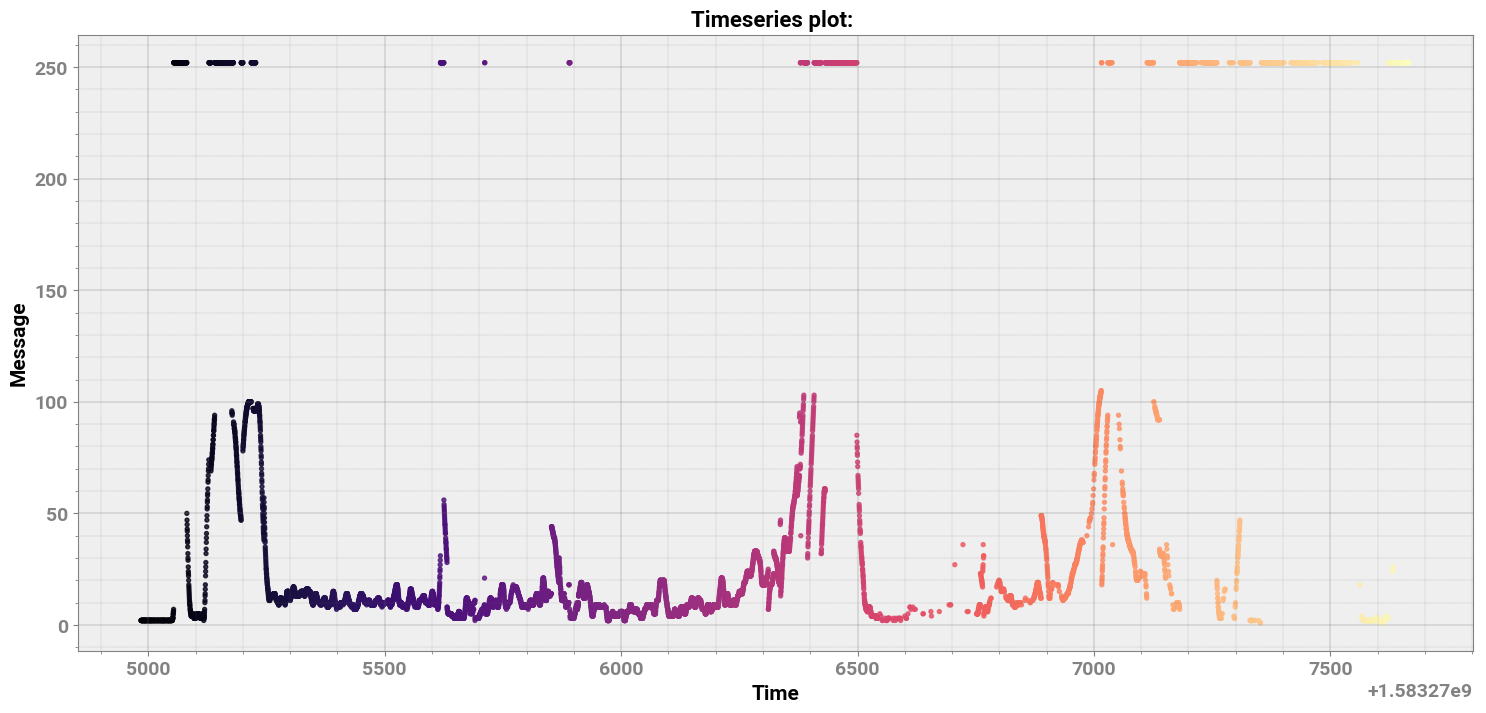

In [9]:
plt.rcParams["figure.figsize"] = (16,5)
headway = r0.get_ts('DSU_CRUISE', 6)
strym.plt_ts(headway)

Now lets filter above distance to remove all distance that is equal to 252m. A distance of 252m tells that there was no vehicle detected in the front.

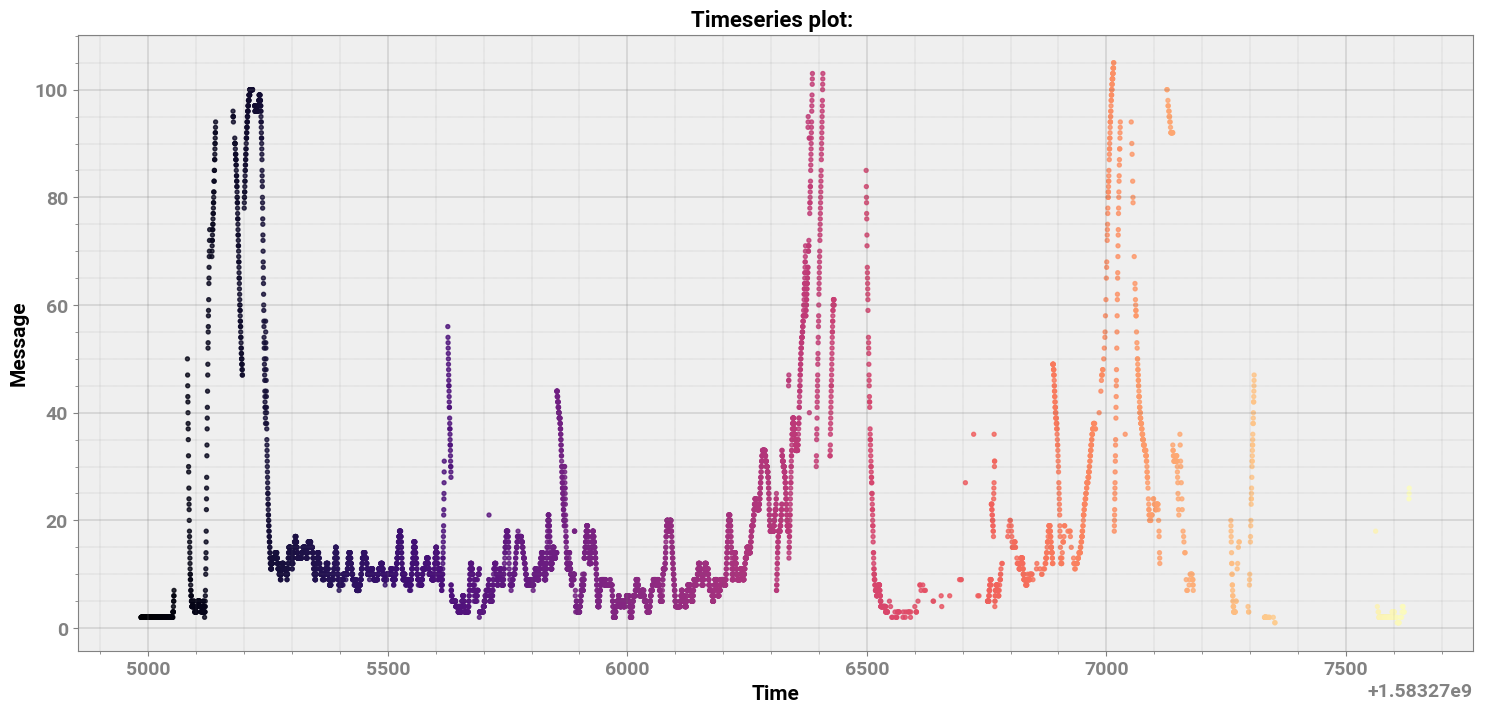

In [10]:
headway_filtered = headway[headway['Message'] < 252]
strym.plt_ts(headway_filtered)

Now we will use `strym`'s inbuilt function `msg_subset` to retrieve a subset of original message

## Now lets specify conditions for subsetting.
Subsetting can be done in following ways: specify elpased-time ranges for which you want all messages, specify a list of particular message id or specify conditions. See the documentation for all options.

In [11]:
print(r0.msg_subset.__doc__)


        Get the subset of message dataframe  based on a condition.

        Parameters
        -------------

        kwargs: variable list of argument in the dictionary format

            conditions: `str` | `list<str>`
            
                Human readable condition for subsetting of message dataframe.
                Following conditions are available:
            
            - "lead vehicle present": Extracts only those messages for which there was lead vehicle present.
            - "cruise control on": Extracts only those messages for which cruise control is on.
            - "operand op x": Extracts those messages for which operator `op` is operated on operand to fulfil `x`. 
            
                Available operators `op` are `[>,<,==, !=, >=,<=]`

                Available operand ``operand` are `[speed, acceleration, lead_distance, steering_angle, steering_rate, yaw_rate ].
                Details of operands are as follows:

                    - speed: timese

There are two ways to get subset of a message. You can either modify original datagrame by passing `inplace=True` to `msg_subset` function or you get a return value as a subset. By default, `inplace=False`. If you don't specify time range, then full dataframe will be used for subsetting. You don't specify a particular message ID, then full dataframe will be used for subsetting.

In [14]:
r_new = r0.msg_subset(conditions="lead vehicle present")

In [15]:
r0.dataframe

,Time,Buffer,Bus,MessageID,Message,MessageLength
Clock,,,,,,
2020-03-03 22:36:24.759860992,1.583275e+09,0000602c05004ef9130f038018000000,0,355,130f038018,5
2020-03-03 22:36:24.760409594,1.583275e+09,000080380800eef90000210056004084,0,452,0000210056004084,8
2020-03-03 22:36:24.761665106,1.583275e+09,00000030180058b4a5fff80000000025,1,384,a5fff80000000025,8
2020-03-03 22:36:24.762725592,1.583275e+09,0000403018004eb6a5fff80000000027,1,386,a5fff80000000027,8
2020-03-03 22:36:24.763091087,1.583275e+09,000060301800cbb6a5fff80000000028,1,387,a5fff80000000028,8
...,...,...,...,...,...,...
2020-03-03 23:21:06.934266090,1.583278e+09,000060500700666b0000000000008c00,0,643,0000000000008c,7
2020-03-03 23:21:06.935342073,1.583278e+09,0000c05c0800606dfff800087fe0004e,0,742,fff800087fe0004e,8
2020-03-03 23:21:06.935601950,1.583278e+09,0000403a08000f6e9904fa54ffae0073,0,466,9904fa54ffae0073,8


In [16]:
r0.dataframe.shape

(3942410, 6)

Now, to check whether subset has been successful, we will plot ('DSU_CRUISE', 6) and the give plot should give headway distance same as filtered headway distance we saw above. Since `strym`'s function originally require passing csvfile to get the benefit or all utility and plotting functions, we need to manual set dataframe to this subset dataframe as we didn't pass `inplace=True`. In future, we will be able to create `strym` object with a valid CAN dataframe.

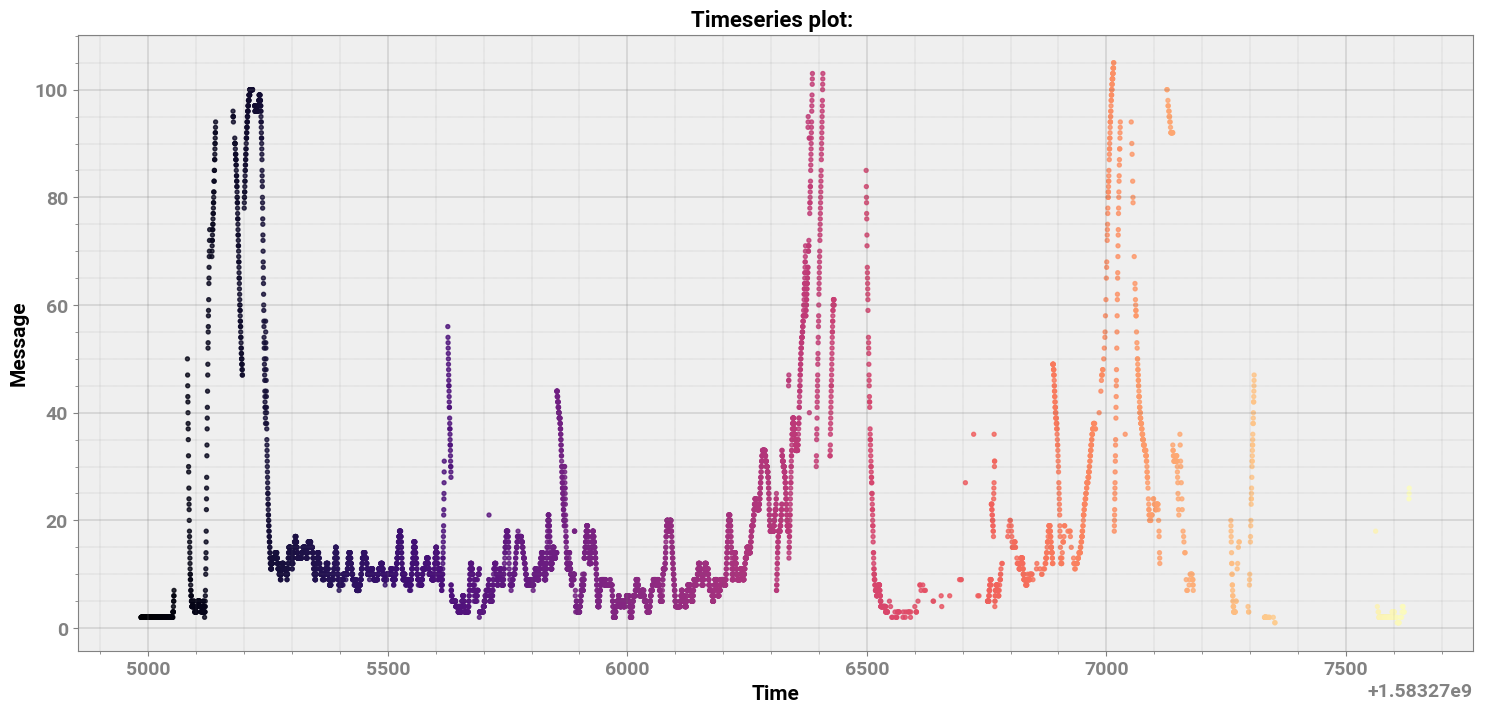

In [17]:
dsu = r_new.get_ts('DSU_CRUISE', 6)
strym.plt_ts(dsu)

For most part, the last two plots above looks same except for clippings at either ends.

## Get the time slices.
We can also get the time slices satisfying the given condition. It can be done using function `time_subset`. Lets see documentation of this function.

In [18]:
print(r0.time_subset.__doc__)


        Get the time slices satsifying a particular condition for the dataframe.

        Parameters
        -------------
        
        kwargs: variable list of argument in the dictionary format

            conditions: `str` | `list<str>`
            
                Human readable condition for subsetting of message dataframe.
                Following conditions are available:
            
            - "lead vehicle present": Extracts only those message for which there was lead vehicle present.
            
        Returns
        --------
        `list`
            A list of tuples with start and end time of slices. E.g. [(t0, t1), (t2, t3), ...] satisfying the given conditions

        


The timeslices cabe used for further analysis.

In [19]:
timeslices = r0.time_subset(conditions="lead vehicle present")
timeslices

[[(Timestamp('2020-03-03 22:36:24.787207365'),
   Timestamp('2020-03-03 22:37:33.590708017')),
  (Timestamp('2020-03-03 22:38:01.589940071'),
   Timestamp('2020-03-03 22:38:47.991396666')),
  (Timestamp('2020-03-03 22:38:52.591384888'),
   Timestamp('2020-03-03 22:39:00.391503572')),
  (Timestamp('2020-03-03 22:39:36.792317629'),
   Timestamp('2020-03-03 22:39:37.592354774')),
  (Timestamp('2020-03-03 22:39:40.392557383'),
   Timestamp('2020-03-03 22:39:56.393051624')),
  (Timestamp('2020-03-03 22:40:00.192902565'),
   Timestamp('2020-03-03 22:40:17.593435049')),
  (Timestamp('2020-03-03 22:40:21.793538094'),
   Timestamp('2020-03-03 22:40:24.993632317')),
  (Timestamp('2020-03-03 22:40:27.393696547'),
   Timestamp('2020-03-03 22:46:57.804323435')),
  (Timestamp('2020-03-03 22:47:05.204793453'),
   Timestamp('2020-03-03 22:48:31.208158493')),
  (Timestamp('2020-03-03 22:48:32.007115126'),
   Timestamp('2020-03-03 22:51:30.012042046')),
  (Timestamp('2020-03-03 22:51:31.412022352'),
   

## Cruise Control ON
Lets look at cruise control information

In [20]:
plt.rcParams["figure.figsize"] = (16,5)
acc_on = r0.acc_state()

In [21]:
rnew_2 = r0.msg_subset(conditions="cruise control on")

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


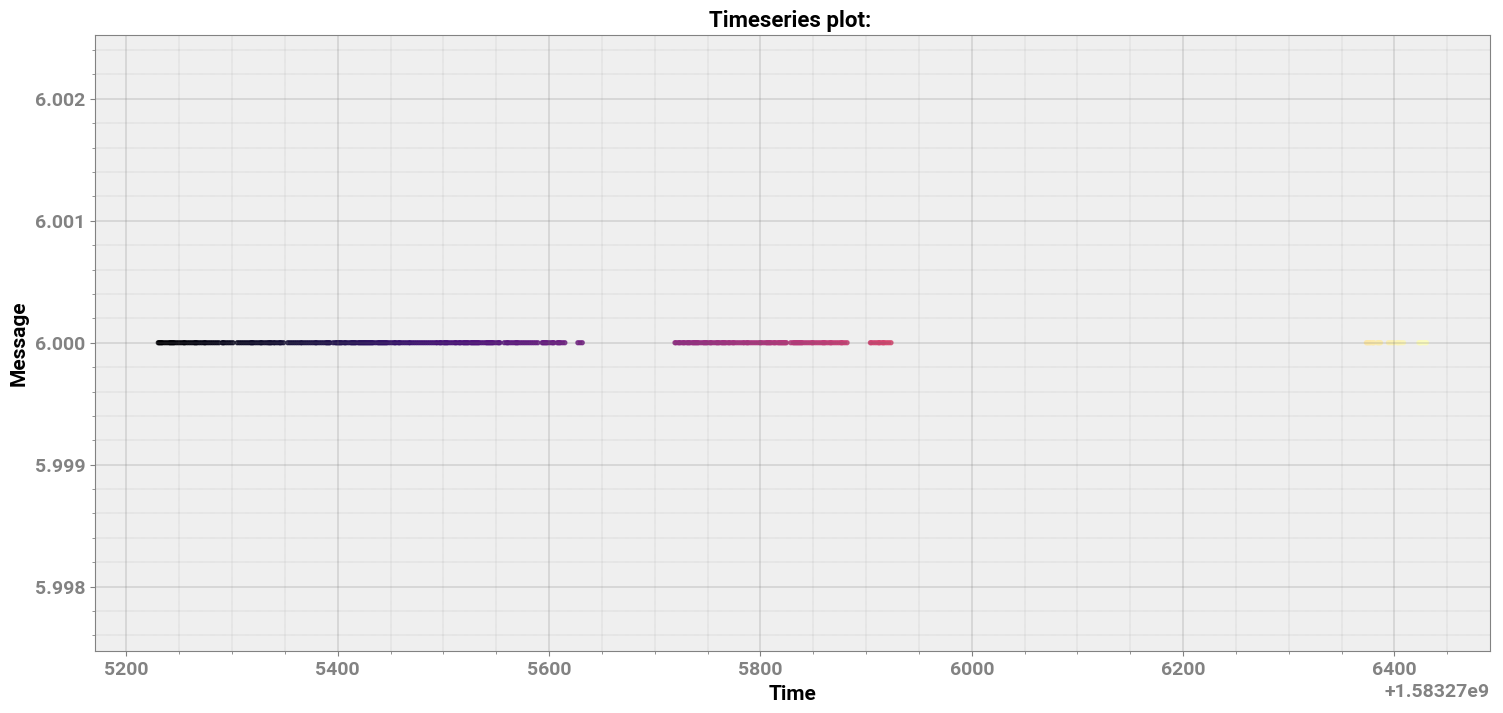

In [23]:
cruise = rnew_2.acc_state()
strym.plt_ts(cruise)

## ID based filtering

In [29]:
r3new = r0.msg_subset(conditions="180.SPEED.Message >= 20")

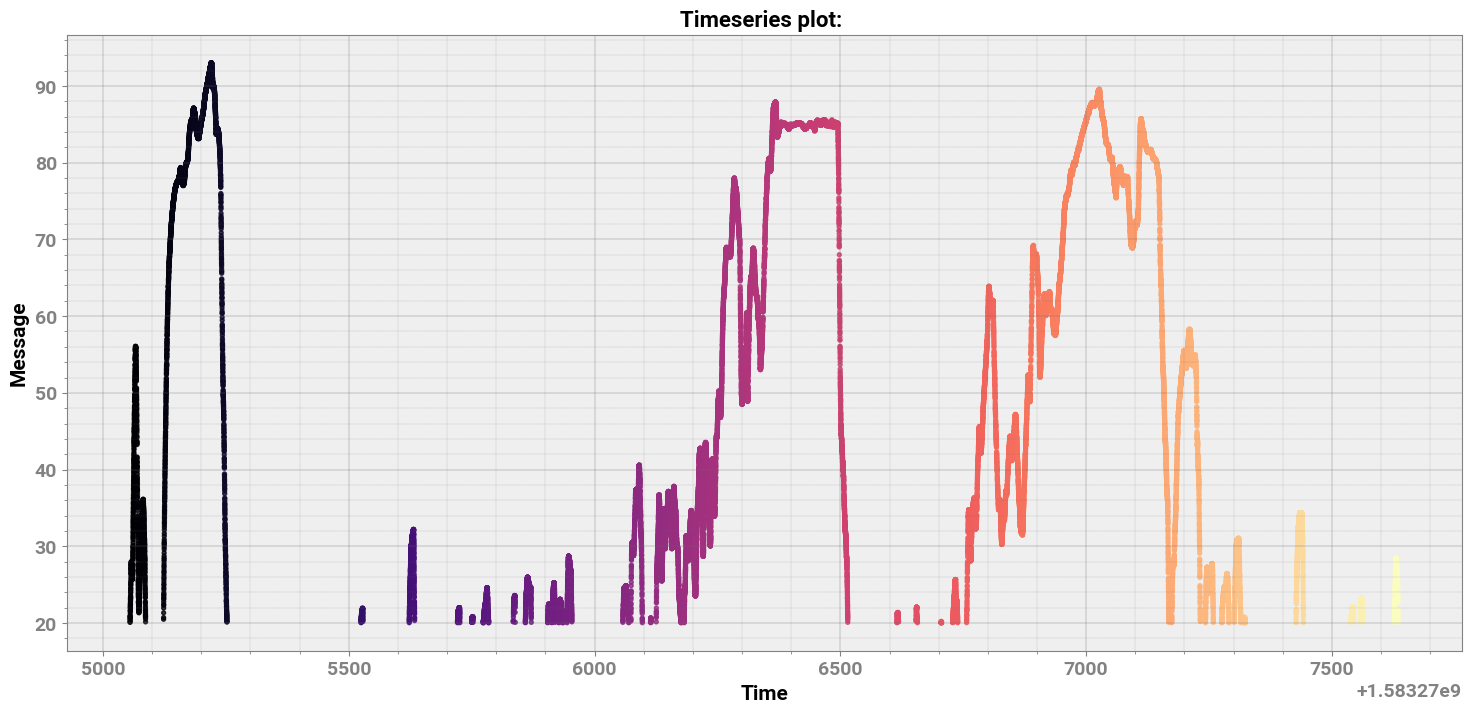

In [30]:
speed_subset = r3new.speed()
plt.rcParams["figure.figsize"] = (16,5)
strym.plt_ts(speed_subset)

In [31]:
subset = r0.msg_subset(conditions="180.")

Unsupported conditions provided. See documentation for more details.


ValueError: Unsupported conditions provided. See documentation for more details.

In [32]:
timeslices = r0.time_subset(conditions=["180.SPEED.Message >= 4", "cruise control on"])

In [33]:
timeslices = r0.time_subset(conditions="cruise control on")

In [34]:
from itertools import chain
timeslices =  list(chain.from_iterable(timeslices)) 
timeslices

[(Timestamp('2020-03-03 22:40:30.250442504'),
  Timestamp('2020-03-03 22:46:54.947874308')),
 (Timestamp('2020-03-03 22:47:07.301365137'),
  Timestamp('2020-03-03 22:47:11.397818565')),
 (Timestamp('2020-03-03 22:48:39.183156490'),
  Timestamp('2020-03-03 22:51:22.000110626')),
 (Timestamp('2020-03-03 22:51:44.094992638'),
  Timestamp('2020-03-03 22:52:03.551586390')),
 (Timestamp('2020-03-03 22:59:33.474892616'),
  Timestamp('2020-03-03 22:59:39.470468760')),
 (Timestamp('2020-03-03 22:59:39.658811569'),
  Timestamp('2020-03-03 22:59:46.827667952')),
 (Timestamp('2020-03-03 22:59:54.273617506'),
  Timestamp('2020-03-03 23:00:08.609681845')),
 (Timestamp('2020-03-03 23:00:23.142306328'),
  Timestamp('2020-03-03 23:00:30.310319901'))]

In [35]:
subset_frames = []
for time_frame in timeslices:
    sliced_frame = r0.dataframe.loc[time_frame[0]: time_frame[1]]
    subset_frames.append(sliced_frame)

In [36]:
subset_frames

[                                       Time                            Buffer  \
 Clock                                                                           
 2020-03-03 22:40:30.250442504  1.583275e+09  000020730800e2781066003700000000   
 2020-03-03 22:40:30.250880480  1.583275e+09  0000607708006c790000c28000000000   
 2020-03-03 22:40:30.251142502  1.583275e+09  000040150800e5793b523b733b583b5a   
 2020-03-03 22:40:30.251735926  1.583275e+09  0000401704004a7b01ed00ac00000000   
 2020-03-03 22:40:30.252018452  1.583275e+09  0000e05c08009c7b7d04000000000072   
 ...                                     ...                               ...   
 2020-03-03 22:46:54.945369959  1.583276e+09  000040150800adc01f371f311f341f34   
 2020-03-03 22:46:54.945670605  1.583276e+09  00008016080036c1000000005504b9ce   
 2020-03-03 22:46:54.945927382  1.583276e+09  0000a0040800aec100000fff5000008b   
 2020-03-03 22:46:54.946479559  1.583276e+09  000080650800d2c20000000000000037   
 2020-03-03 22:4

In [37]:
type(r0.dataframe)

pandas.core.frame.DataFrame

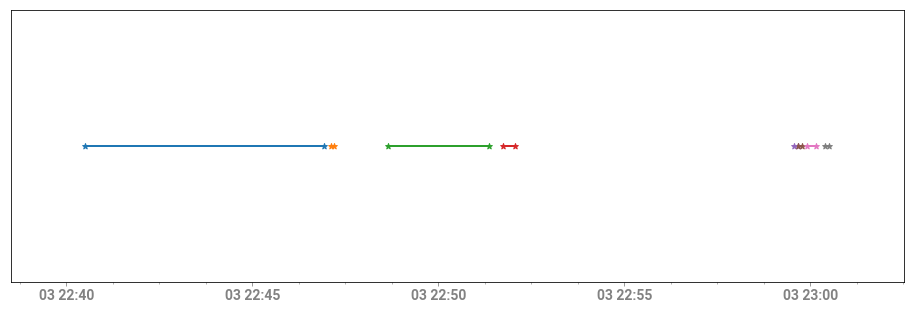

In [38]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,5)
for slices in timeslices:
    plt.scatter([slices[0], slices[1]], [0, 0], marker = '*')
    plt.plot([slices[0], slices[1]], [0, 0], linewidth=2.0)
    plt.xlim([np.min(timeslices)-0.1*(np.max(timeslices)-np.min(timeslices)), np.max(timeslices)+0.1*(np.max(timeslices)-np.min(timeslices))])
    plt.ylim([-0.0001, 0.0001])
plt.yticks([])
plt.show()